In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_id = '1r4T5zff_e6ZDbVjsrBy_6AY1kf9RUJ67'
file_id2='16_CLJcTWC8pLyFvuZpoS2MsPRMFI7WQA'
file_id3='1PG5Iy6XvBYc7GD-eDFH_xW0xLOlx44Cf'
downloaded = drive.CreateFile({'id': file_id2})
downloaded.GetContentFile('data.csv') 

import pandas as pd
df = pd.read_csv('data.csv') 
df.head()

,tag,starter_content
0,24,dear community in 2015 we are going to do a be...
1,6,this post is partially out of boredom looking ...
2,5,hi i have a coffee grinder that my employees a...
3,7,ok i’m ready to finally share this with the co...
4,4,the fibaro fgk101 temperature doorwindow senso...


In [6]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df, test_size=.2, random_state=2)
train, valid = train_test_split(train, test_size=.2, random_state=2)
print(len(train))
print(len(valid))
print(len(test))
print(train.head())

320
80
100
     tag                                    starter_content
475    1  hello i am struggling to get my samsung smart ...
31     6  there are a million threads about this and i f...
336    7  announcing bigtalker 20 release important noti...
449    4  zwave tweaker version 008 20170316 source http...
333   10  hey guys is there any way to increase or decre...


In [8]:
!pip install pytorch-transformers
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
bert_model = "bert-base-uncased"
max_seq_len = 128
batch_size = 32

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 890kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 17.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=99c25c203e846856b5c90408f5ae46c214a07fd6e5f6627c5551ce0212f72fcf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [9]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

100%|██████████| 231508/231508 [00:00<00:00, 4279974.48B/s]


In [10]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [11]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)
path = Path(".")

In [12]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="starter_content",
                  label_cols='tag',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )
databunch.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
26, 17
  if getattr(ds, 'warn', False): warn(ds.warn)


text,target
[CLS] hi all currently researching available smart ##val ##ves stu ##bled over this thing on amazon https : / / www . amazon . com / d ##p / b ##0 ##7 ##k ##x ##l ##x ##g ##2 ##p / ? coli ##id = i ##2 ##ia ##pw ##1 ##m ##r ##0 ##w ##hi ##w & coli ##d = 1910 ##du ##bu ##j ##4 ##po ##h & ps ##c =,6
[CLS] i just order the ad ##t smart ##thing ##s starter kit as a replacement home security my iris system is ending for those of us who do not turn our phones on much i realize that setup needs to be done via the app but is there a website that allows some functionality on a website i prefer to do things on my desktop pc rather than an app,2
[CLS] i ’ m attempting to write a device handler for some r ##gb strips in order to control them from other sources like google home etc i ’ m implementing the brightness slide ##r switch ##lev ##el as a mode select ie user picks 5 brightness it tells the r ##gb strip to use light mode 5 this is all working fine each mode has text associated with it,11
[CLS] i wrote a small device handler that works perfectly in the classic app to take pictures of my doorbell i realize from a few posts that this only works in the classic app is this going to change will the new app ever support this functionality also the automation ##s allow you to attach photo to notification ##s how does this work i would like to use the camera,1
[CLS] hi everyone i ’ m sharing here my wi ##p aqua connect device handler for hayward pool automation it ’ s working well but features are a bit limited by the architecture of the aqua connect bridge still you can view current status of the pool lights heat ##er filter and aux relay ##s control the lights mode and filter easily sadly the model ##ight ##s will not show,4


In [13]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [14]:
from collections import defaultdict
cate = defaultdict(int)
category=list(train.tag)
for i in range(len(train)):
    cate[str(category[i])] += 1
len(cate)#how many labels in train set

24

In [15]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=len(cate))

100%|██████████| 440473133/440473133 [00:06<00:00, 70408229.77B/s]


In [16]:
loss_func = nn.CrossEntropyLoss()

In [17]:
learn = Learner(databunch,
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


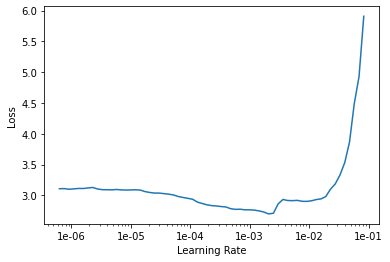

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.938695,2.154288,0.371795,06:45
1,2.704746,2.171687,0.371795,06:46
